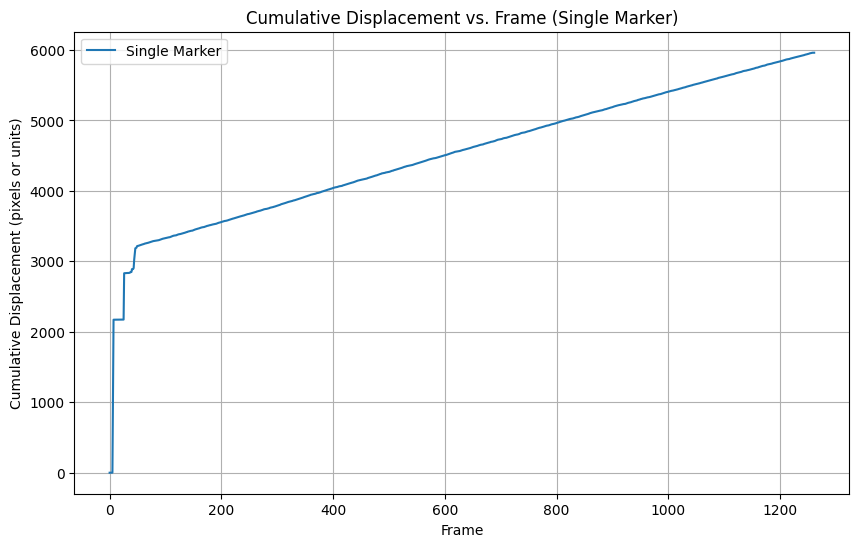

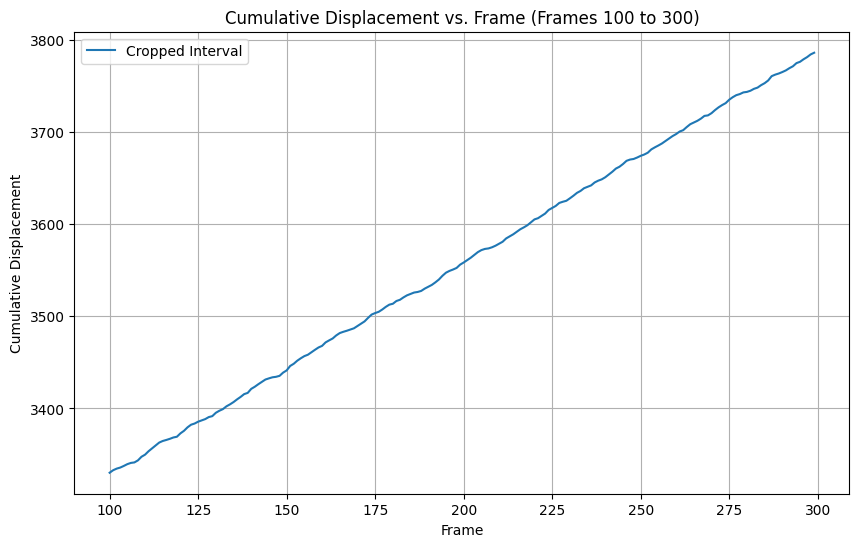

In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# File path
file_path = '/Users/jamesxu/Desktop/Crab Lab/surface swimmer/newCoasting/40cm/40cm_run7DLC_resnet50_part1Dec10shuffle1_100000_filtered.csv'

# Load the CSV
df = pd.read_csv(file_path)

# The second line (index=1) contains the actual bodypart coordinate labels (x,y)
columns = df.iloc[1].tolist()
coordinate_columns = [i for i, val in enumerate(columns) if val in ['x', 'y']]

# For the first marker (bodypart1)
x_index_1 = coordinate_columns[0]
y_index_1 = coordinate_columns[1]

# For the second marker (bodypart2), assuming it follows immediately after the first marker:
x_index_2 = coordinate_columns[2]
y_index_2 = coordinate_columns[3]

# Extract coordinates for marker 1
x1 = df.iloc[2:, x_index_1].astype(float)
y1 = df.iloc[2:, y_index_1].astype(float)

dx1 = x1.diff().fillna(0)
dy1 = y1.diff().fillna(0)
distance_per_frame_1 = np.sqrt(dx1**2 + dy1**2)
cumulative_displacement_1 = distance_per_frame_1.cumsum()

frames_1 = np.arange(len(cumulative_displacement_1))

# Extract coordinates for marker 2
x2 = df.iloc[2:, x_index_2].astype(float)
y2 = df.iloc[2:, y_index_2].astype(float)

dx2 = x2.diff().fillna(0)
dy2 = y2.diff().fillna(0)
distance_per_frame_2 = np.sqrt(dx2**2 + dy2**2)
cumulative_displacement_2 = distance_per_frame_2.cumsum()

frames_2 = np.arange(len(cumulative_displacement_2))

# Plot both markers in one figure for comparison
plt.figure(figsize=(10,6))
plt.plot(frames_1, cumulative_displacement_1, label='Marker 1 (Bodypart1)')
plt.plot(frames_2, cumulative_displacement_2, label='Marker 2 (Bodypart2)')
plt.title('Cumulative Displacement vs. Frame')
plt.xlabel('Frame')
plt.ylabel('Cumulative Displacement (pixels or units)')
plt.grid(True)
plt.legend()
plt.show()

# Now plot a cropped interval, e.g., frames 100 to 300, for both markers
start_frame = 100
end_frame = 300
if end_frame <= len(cumulative_displacement_1) and end_frame <= len(cumulative_displacement_2):
    plt.figure(figsize=(10,6))
    plt.plot(frames_1[start_frame:end_frame], cumulative_displacement_1[start_frame:end_frame], label='Marker 1 (Cropped)')
    plt.plot(frames_2[start_frame:end_frame], cumulative_displacement_2[start_frame:end_frame], label='Marker 2 (Cropped)')
    plt.title(f'Cumulative Displacement vs. Frame (Frames {start_frame} to {end_frame})')
    plt.xlabel('Frame')
    plt.ylabel('Cumulative Displacement')
    plt.grid(True)
    plt.legend()
    plt.show()
else:
    print("Not enough frames to plot the specified interval for both markers.")


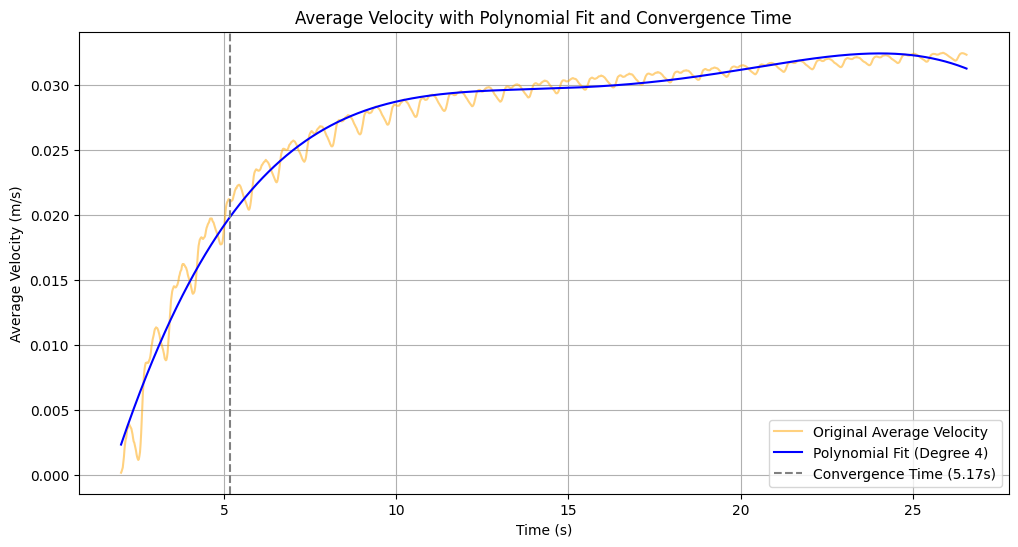

The system reaches 1 - 1/e of the maximum average velocity (0.0198 m/s) at t = 5.17 seconds.
The coasting # is: 4.27


In [127]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def analyze_and_plot(file_path, x_length_meters=1.6, y_length_meters=0.9, fps=60, start_time=2, end_time=30, poly_degree=3):
    # Load the CSV file
    df = pd.read_csv(file_path)
    
    # Define normalization factors 
    y_length_pixels = pd.to_numeric(df.iloc[2:, 1::2].max().max(), errors='coerce') - pd.to_numeric(df.iloc[2:, 1::2].min().min(), errors='coerce')
    normalization_factor_y = y_length_meters / y_length_pixels

    x_length_pixels = pd.to_numeric(df.iloc[2:, ::2].max().max(), errors='coerce') - pd.to_numeric(df.iloc[2:, ::2].min().min(), errors='coerce')
    normalization_factor_x = x_length_meters / x_length_pixels

    # Extract x and y coordinates for the markers, skipping the first two rows
    coordinates_df = df.iloc[2:, :44].apply(pd.to_numeric, errors='coerce')  # Ensure numeric values

    # Separate x and y coordinates and normalize them
    x_coords = coordinates_df.iloc[:, ::2] * normalization_factor_x  # Normalize x-coordinates
    y_coords = coordinates_df.iloc[:, 1::2] * normalization_factor_y  # Normalize y-coordinates

    # Calculate mean position over markers
    mean_x_position = x_coords.mean(axis=1).values
    mean_y_position = y_coords.mean(axis=1).values
    
    # Time array
    time = np.arange(len(mean_x_position)) / fps

    # Crop the data based on the start and end times
    start_index = int(start_time * fps)
    end_index = int(end_time * fps)
    time = time[start_index:end_index]
    mean_x_position = mean_x_position[start_index:end_index]
    mean_y_position = mean_y_position[start_index:end_index]

    # --- Average Velocity Calculation ---
    # Calculate displacement from initial position at each time point
    displacement_x = mean_x_position - mean_x_position[0]
    displacement_y = mean_y_position - mean_y_position[0]
    total_displacement = np.sqrt(displacement_x**2 + displacement_y**2)
    
    # Avoid division by zero at t=0 by starting from index 1
    average_velocity = total_displacement[1:] / time[1:]

    # Polynomial fit to the average velocity
    poly_coeffs = np.polyfit(time[1:], average_velocity, poly_degree)
    poly_fit = np.polyval(poly_coeffs, time[1:])

    # Calculate the 1 - 1/e value of the maximum average velocity
    max_velocity = poly_fit[-1]  # Value at the last time point of the polynomial fit
    threshold_velocity = (1 - 1/np.e) * max_velocity  # Approximately 0.632 * max_velocity

    # Find the time where the polynomial fit meets this threshold
    threshold_index = np.where(poly_fit >= threshold_velocity)[0][0]
    convergence_time = time[1:][threshold_index]
    
    #
    temp_freq = 1.21
    coasting_num = convergence_time/temp_freq

    # --- Plot Original, Polynomial Fit, and Threshold ---
    plt.figure(figsize=(12, 6))
    plt.plot(time[1:], average_velocity, label='Original Average Velocity', color='orange', alpha=0.5)
    plt.plot(time[1:], poly_fit, label=f'Polynomial Fit (Degree {poly_degree})', color='blue')
    plt.axvline(x=convergence_time, color='gray', linestyle='--', label=f'Convergence Time ({convergence_time:.2f}s)')
    plt.xlabel('Time (s)')
    plt.ylabel('Average Velocity (m/s)')
    plt.title('Average Velocity with Polynomial Fit and Convergence Time')
    plt.legend()
    plt.grid(True)
    plt.show()

    print(f'The system reaches 1 - 1/e of the maximum average velocity ({threshold_velocity:.4f} m/s) at t = {convergence_time:.2f} seconds.')
    print(f'The coasting # is: {coasting_num:.2f}')

# Path to the CSV file
file_path = '/Users/jamesxu/Desktop/Crab Lab/surface swimmer/vel_steadyState/24cm_run8.csv'

# Run the function with polynomial fit
analyze_and_plot(file_path, poly_degree=4)


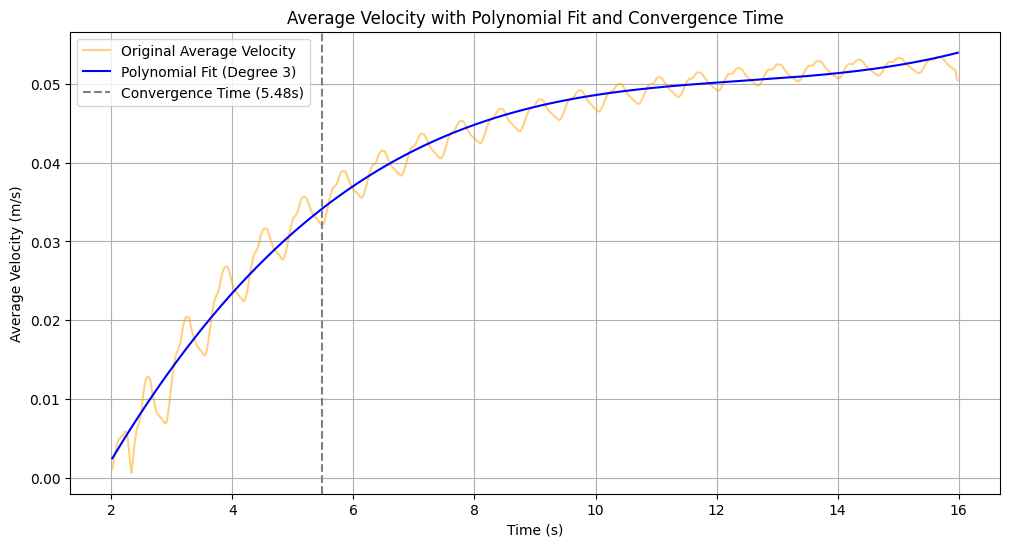

The system reaches 1 - 1/e of the maximum average velocity (0.0341 m/s) at t = 5.48 seconds.
The coasting # is: 4.53


In [69]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def analyze_and_plot(file_path, x_length_meters=1.6, y_length_meters=0.9, fps=60, start_time=2, end_time=16, poly_degree=3):
    # Load the CSV file
    df = pd.read_csv(file_path)
    
    # Define normalization factors 
    y_length_pixels = pd.to_numeric(df.iloc[2:, 1::2].max().max(), errors='coerce') - pd.to_numeric(df.iloc[2:, 1::2].min().min(), errors='coerce')
    normalization_factor_y = y_length_meters / y_length_pixels

    x_length_pixels = pd.to_numeric(df.iloc[2:, ::2].max().max(), errors='coerce') - pd.to_numeric(df.iloc[2:, ::2].min().min(), errors='coerce')
    normalization_factor_x = x_length_meters / x_length_pixels

    # Extract x and y coordinates for the markers, skipping the first two rows
    coordinates_df = df.iloc[2:, :44].apply(pd.to_numeric, errors='coerce')  # Ensure numeric values

    # Separate x and y coordinates and normalize them
    x_coords = coordinates_df.iloc[:, ::2] * normalization_factor_x  # Normalize x-coordinates
    y_coords = coordinates_df.iloc[:, 1::2] * normalization_factor_y  # Normalize y-coordinates

    # Calculate mean position over markers
    mean_x_position = x_coords.mean(axis=1).values
    mean_y_position = y_coords.mean(axis=1).values
    
    # Time array
    time = np.arange(len(mean_x_position)) / fps

    # Crop the data based on the start and end times
    start_index = int(start_time * fps)
    end_index = int(end_time * fps)
    time = time[start_index:end_index]
    mean_x_position = mean_x_position[start_index:end_index]
    mean_y_position = mean_y_position[start_index:end_index]

    # --- Average Velocity Calculation ---
    # Calculate displacement from initial position at each time point
    displacement_x = mean_x_position - mean_x_position[0]
    displacement_y = mean_y_position - mean_y_position[0]
    total_displacement = np.sqrt(displacement_x**2 + displacement_y**2)
    
    # Avoid division by zero at t=0 by starting from index 1
    average_velocity = total_displacement[1:] / time[1:]

    # Polynomial fit to the average velocity
    poly_coeffs = np.polyfit(time[1:], average_velocity, poly_degree)
    poly_fit = np.polyval(poly_coeffs, time[1:])

    # Calculate the 1 - 1/e value of the maximum average velocity
    max_velocity = poly_fit[-1]  # Value at the last time point of the polynomial fit
    threshold_velocity = (1 - 1/np.e) * max_velocity  # Approximately 0.632 * max_velocity

    # Find the time where the polynomial fit meets this threshold
    threshold_index = np.where(poly_fit >= threshold_velocity)[0][0]
    convergence_time = time[1:][threshold_index]
    #
    temp_freq = 1.21
    coasting_num = convergence_time/temp_freq


    # --- Plot Original, Polynomial Fit, and Threshold ---
    plt.figure(figsize=(12, 6))
    plt.plot(time[1:], average_velocity, label='Original Average Velocity', color='orange', alpha=0.5)
    plt.plot(time[1:], poly_fit, label=f'Polynomial Fit (Degree {poly_degree})', color='blue')
    plt.axvline(x=convergence_time, color='gray', linestyle='--', label=f'Convergence Time ({convergence_time:.2f}s)')
    plt.xlabel('Time (s)')
    plt.ylabel('Average Velocity (m/s)')
    plt.title('Average Velocity with Polynomial Fit and Convergence Time')
    plt.legend()
    plt.grid(True)
    plt.show()

    print(f'The system reaches 1 - 1/e of the maximum average velocity ({threshold_velocity:.4f} m/s) at t = {convergence_time:.2f} seconds.')
    print(f'The coasting # is: {coasting_num:.2f}')

# Path to the CSV file
file_path = '/Users/jamesxu/Desktop/Crab Lab/surface swimmer/vel_steadyState/32cm_run9.csv'

# Run the function with polynomial fit
analyze_and_plot(file_path, poly_degree=3)



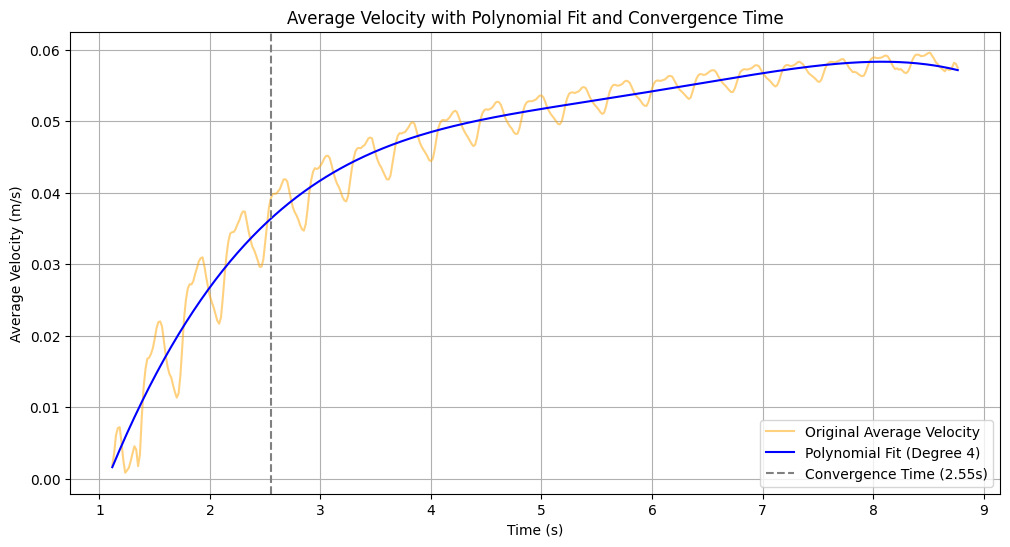

The system reaches 1 - 1/e of the maximum average velocity (0.0361 m/s) at t = 2.55 seconds.
The coasting # is: 2.11


In [157]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def analyze_and_plot(file_path, x_length_meters=1.6, y_length_meters=0.9, fps=60, start_time=1.1, end_time=20, poly_degree=3):
    # Load the CSV file
    df = pd.read_csv(file_path)
    
    # Define normalization factors 
    y_length_pixels = pd.to_numeric(df.iloc[2:, 1::2].max().max(), errors='coerce') - pd.to_numeric(df.iloc[2:, 1::2].min().min(), errors='coerce')
    normalization_factor_y = y_length_meters / y_length_pixels

    x_length_pixels = pd.to_numeric(df.iloc[2:, ::2].max().max(), errors='coerce') - pd.to_numeric(df.iloc[2:, ::2].min().min(), errors='coerce')
    normalization_factor_x = x_length_meters / x_length_pixels

    # Extract x and y coordinates for the markers, skipping the first two rows
    coordinates_df = df.iloc[2:, :44].apply(pd.to_numeric, errors='coerce')  # Ensure numeric values

    # Separate x and y coordinates and normalize them
    x_coords = coordinates_df.iloc[:, ::2] * normalization_factor_x  # Normalize x-coordinates
    y_coords = coordinates_df.iloc[:, 1::2] * normalization_factor_y  # Normalize y-coordinates

    # Calculate mean position over markers
    mean_x_position = x_coords.mean(axis=1).values
    mean_y_position = y_coords.mean(axis=1).values
    
    # Time array
    time = np.arange(len(mean_x_position)) / fps

    # Crop the data based on the start and end times
    start_index = int(start_time * fps)
    end_index = int(end_time * fps)
    time = time[start_index:end_index]
    mean_x_position = mean_x_position[start_index:end_index]
    mean_y_position = mean_y_position[start_index:end_index]

    # --- Average Velocity Calculation ---
    # Calculate displacement from initial position at each time point
    displacement_x = mean_x_position - mean_x_position[0]
    displacement_y = mean_y_position - mean_y_position[0]
    total_displacement = np.sqrt(displacement_x**2 + displacement_y**2)
    
    # Avoid division by zero at t=0 by starting from index 1
    average_velocity = total_displacement[1:] / time[1:]

    # Polynomial fit to the average velocity
    poly_coeffs = np.polyfit(time[1:], average_velocity, poly_degree)
    poly_fit = np.polyval(poly_coeffs, time[1:])

    # Calculate the 1 - 1/e value of the maximum average velocity
    max_velocity = poly_fit[-1]  # Value at the last time point of the polynomial fit
    threshold_velocity = (1 - 1/np.e) * max_velocity  # Approximately 0.632 * max_velocity

    # Find the time where the polynomial fit meets this threshold
    threshold_index = np.where(poly_fit >= threshold_velocity)[0][0]
    convergence_time = time[1:][threshold_index]
    #
    temp_freq = 1.21
    coasting_num = convergence_time/temp_freq


    # --- Plot Original, Polynomial Fit, and Threshold ---
    plt.figure(figsize=(12, 6))
    plt.plot(time[1:], average_velocity, label='Original Average Velocity', color='orange', alpha=0.5)
    plt.plot(time[1:], poly_fit, label=f'Polynomial Fit (Degree {poly_degree})', color='blue')
    plt.axvline(x=convergence_time, color='gray', linestyle='--', label=f'Convergence Time ({convergence_time:.2f}s)')
    plt.xlabel('Time (s)')
    plt.ylabel('Average Velocity (m/s)')
    plt.title('Average Velocity with Polynomial Fit and Convergence Time')
    plt.legend()
    plt.grid(True)
    plt.show()

    print(f'The system reaches 1 - 1/e of the maximum average velocity ({threshold_velocity:.4f} m/s) at t = {convergence_time:.2f} seconds.')
    print(f'The coasting # is: {coasting_num:.2f}')

# Path to the CSV file
file_path = '/Users/jamesxu/Desktop/Crab Lab/surface swimmer/vel_steadyState/40cm_run3.csv'

# Run the function with polynomial fit
analyze_and_plot(file_path, poly_degree=4)



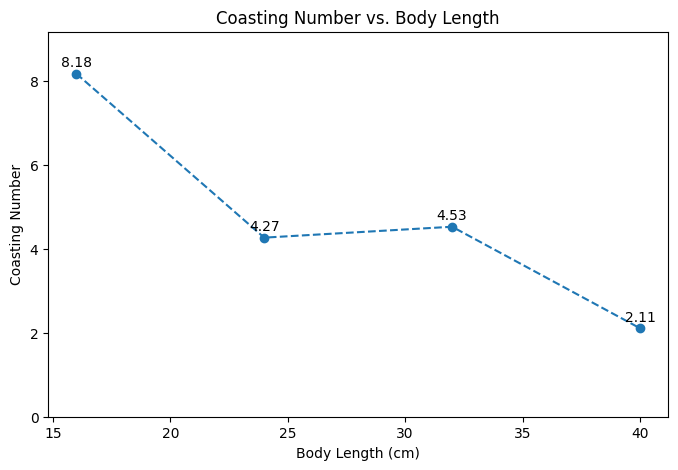

In [158]:
import matplotlib.pyplot as plt

# Data for plotting
body_length = [16, 24, 32, 40]  # in cm
coasting_number = [8.18, 4.27, 4.53, 2.11]

# Plot
plt.figure(figsize=(8, 5))
plt.plot(body_length, coasting_number, marker='o', linestyle='--')  # Dashed line style
plt.title("Coasting Number vs. Body Length")
plt.xlabel("Body Length (cm)")
plt.ylabel("Coasting Number")
plt.ylim(0, max(coasting_number) + 1)  # Start y-axis from zero

# Adding data labels
for i, txt in enumerate(coasting_number):
    plt.annotate(f"{txt}", (body_length[i], coasting_number[i]), textcoords="offset points", xytext=(0, 5), ha='center')

plt.show()


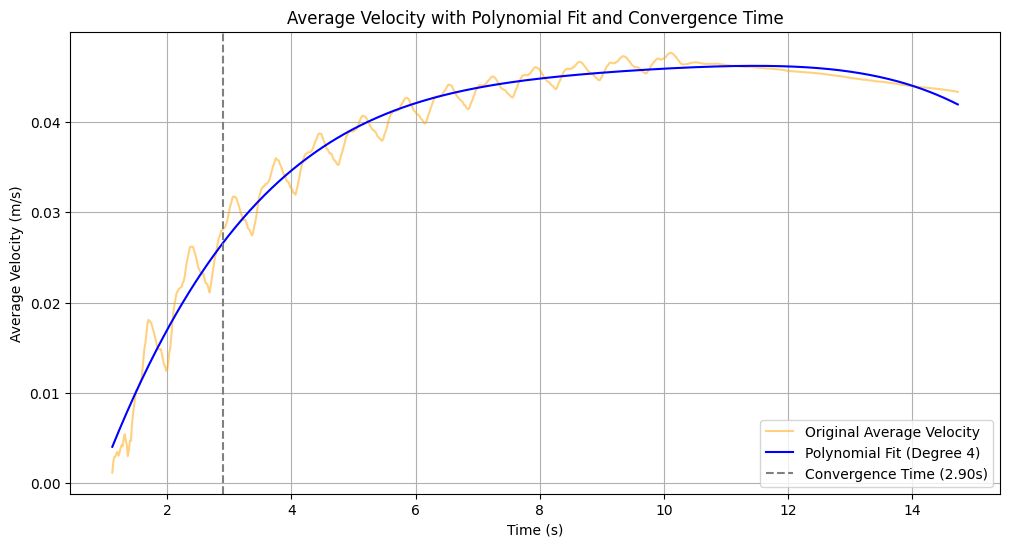

The system reaches 1 - 1/e of the maximum average velocity (0.0265 m/s) at t = 2.90 seconds.
The coasting # is: 2.40


In [159]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def analyze_and_plot(file_path, x_length_meters=1.6, y_length_meters=0.9, fps=60, start_time=1.1, end_time=20, poly_degree=3):
    # Load the CSV file
    df = pd.read_csv(file_path)
    
    # Define normalization factors 
    y_length_pixels = pd.to_numeric(df.iloc[2:, 1::2].max().max(), errors='coerce') - pd.to_numeric(df.iloc[2:, 1::2].min().min(), errors='coerce')
    normalization_factor_y = y_length_meters / y_length_pixels

    x_length_pixels = pd.to_numeric(df.iloc[2:, ::2].max().max(), errors='coerce') - pd.to_numeric(df.iloc[2:, ::2].min().min(), errors='coerce')
    normalization_factor_x = x_length_meters / x_length_pixels

    # Extract x and y coordinates for the markers, skipping the first two rows
    coordinates_df = df.iloc[2:, :44].apply(pd.to_numeric, errors='coerce')  # Ensure numeric values

    # Separate x and y coordinates and normalize them
    x_coords = coordinates_df.iloc[:, ::2] * normalization_factor_x  # Normalize x-coordinates
    y_coords = coordinates_df.iloc[:, 1::2] * normalization_factor_y  # Normalize y-coordinates

    # Calculate mean position over markers
    mean_x_position = x_coords.mean(axis=1).values
    mean_y_position = y_coords.mean(axis=1).values
    
    # Time array
    time = np.arange(len(mean_x_position)) / fps

    # Crop the data based on the start and end times
    start_index = int(start_time * fps)
    end_index = int(end_time * fps)
    time = time[start_index:end_index]
    mean_x_position = mean_x_position[start_index:end_index]
    mean_y_position = mean_y_position[start_index:end_index]

    # --- Average Velocity Calculation ---
    # Calculate displacement from initial position at each time point
    displacement_x = mean_x_position - mean_x_position[0]
    displacement_y = mean_y_position - mean_y_position[0]
    total_displacement = np.sqrt(displacement_x**2 + displacement_y**2)
    
    # Avoid division by zero at t=0 by starting from index 1
    average_velocity = total_displacement[1:] / time[1:]

    # Polynomial fit to the average velocity
    poly_coeffs = np.polyfit(time[1:], average_velocity, poly_degree)
    poly_fit = np.polyval(poly_coeffs, time[1:])

    # Calculate the 1 - 1/e value of the maximum average velocity
    max_velocity = poly_fit[-1]  # Value at the last time point of the polynomial fit
    threshold_velocity = (1 - 1/np.e) * max_velocity  # Approximately 0.632 * max_velocity

    # Find the time where the polynomial fit meets this threshold
    threshold_index = np.where(poly_fit >= threshold_velocity)[0][0]
    convergence_time = time[1:][threshold_index]
    #
    temp_freq = 1.21
    coasting_num = convergence_time/temp_freq


    # --- Plot Original, Polynomial Fit, and Threshold ---
    plt.figure(figsize=(12, 6))
    plt.plot(time[1:], average_velocity, label='Original Average Velocity', color='orange', alpha=0.5)
    plt.plot(time[1:], poly_fit, label=f'Polynomial Fit (Degree {poly_degree})', color='blue')
    plt.axvline(x=convergence_time, color='gray', linestyle='--', label=f'Convergence Time ({convergence_time:.2f}s)')
    plt.xlabel('Time (s)')
    plt.ylabel('Average Velocity (m/s)')
    plt.title('Average Velocity with Polynomial Fit and Convergence Time')
    plt.legend()
    plt.grid(True)
    plt.show()

    print(f'The system reaches 1 - 1/e of the maximum average velocity ({threshold_velocity:.4f} m/s) at t = {convergence_time:.2f} seconds.')
    print(f'The coasting # is: {coasting_num:.2f}')

# Path to the CSV file
file_path = '/Users/jamesxu/Downloads/coasting_luckyshot_16cm/videos/coastingDLC_resnet50_coastingNov13shuffle1_100000_filtered.csv'

# Run the function with polynomial fit
analyze_and_plot(file_path, poly_degree=4)



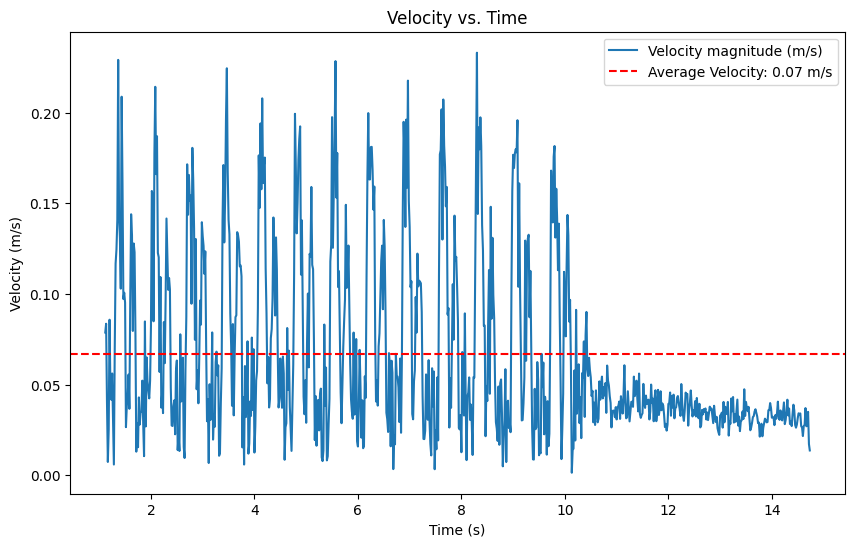

In [170]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load the CSV file
df = pd.read_csv(file_path)
file_path = '/Users/jamesxu/Downloads/coasting_luckyshot_16cm/videos/coastingDLC_resnet50_coastingNov13shuffle1_100000_filtered.csv'

x_length_meters=1.6
y_length_meters=0.9
fps=60
start_time=1.1
end_time=20

# Define normalization factors 
y_length_pixels = pd.to_numeric(df.iloc[2:, 1::2].max().max(), errors='coerce') - pd.to_numeric(df.iloc[2:, 1::2].min().min(), errors='coerce')
normalization_factor_y = y_length_meters / y_length_pixels

x_length_pixels = pd.to_numeric(df.iloc[2:, ::2].max().max(), errors='coerce') - pd.to_numeric(df.iloc[2:, ::2].min().min(), errors='coerce')
normalization_factor_x = x_length_meters / x_length_pixels

# Extract x and y coordinates for the markers, skipping the first two rows
coordinates_df = df.iloc[2:, :44].apply(pd.to_numeric, errors='coerce')  # Ensure numeric values

# Separate x and y coordinates and normalize them
x_coords = coordinates_df.iloc[:, ::2] * normalization_factor_x  # Normalize x-coordinates
y_coords = coordinates_df.iloc[:, 1::2] * normalization_factor_y  # Normalize y-coordinates

# Calculate mean position over markers
mean_x_position = x_coords.mean(axis=1).values
mean_y_position = y_coords.mean(axis=1).values

# Time array
time = np.arange(len(mean_x_position)) / fps

# Crop the data based on the start and end times
start_index = int(start_time * fps)
end_index = int(end_time * fps)
time = time[start_index:end_index]
mean_x_position = mean_x_position[start_index:end_index]
mean_y_position = mean_y_position[start_index:end_index]

# Calculate the velocity using finite differences
velocity_x = np.diff(mean_x_position) * fps  # Velocity in x-direction
velocity_y = np.diff(mean_y_position) * fps  # Velocity in y-direction

# Combine x and y velocities to get the magnitude of the velocity vector
velocity_magnitude = np.sqrt(velocity_x**2 + velocity_y**2)

# Average velocity
average_velocity = np.mean(velocity_magnitude)

# Adjust the time array for velocity (since it has one less element due to diff)
velocity_time = time[1:]

# Plot velocity vs. time
plt.figure(figsize=(10, 6))
plt.plot(velocity_time, velocity_magnitude, label="Velocity magnitude (m/s)")
plt.axhline(y=average_velocity, color='r', linestyle='--', label=f"Average Velocity: {average_velocity:.2f} m/s")
plt.xlabel("Time (s)")
plt.ylabel("Velocity (m/s)")
plt.title("Velocity vs. Time")
plt.legend()
plt.show()


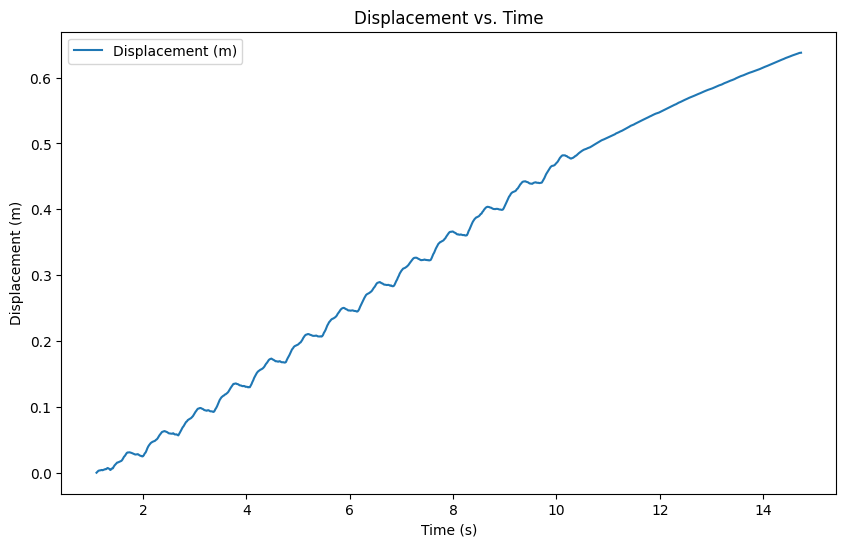

In [167]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load the CSV file
df = pd.read_csv(file_path)

# Define normalization factors 
y_length_pixels = pd.to_numeric(df.iloc[2:, 1::2].max().max(), errors='coerce') - pd.to_numeric(df.iloc[2:, 1::2].min().min(), errors='coerce')
normalization_factor_y = y_length_meters / y_length_pixels

x_length_pixels = pd.to_numeric(df.iloc[2:, ::2].max().max(), errors='coerce') - pd.to_numeric(df.iloc[2:, ::2].min().min(), errors='coerce')
normalization_factor_x = x_length_meters / x_length_pixels

# Extract x and y coordinates for the markers, skipping the first two rows
coordinates_df = df.iloc[2:, :44].apply(pd.to_numeric, errors='coerce')  # Ensure numeric values

# Separate x and y coordinates and normalize them
x_coords = coordinates_df.iloc[:, ::2] * normalization_factor_x  # Normalize x-coordinates
y_coords = coordinates_df.iloc[:, 1::2] * normalization_factor_y  # Normalize y-coordinates

# Calculate mean position over markers
mean_x_position = x_coords.mean(axis=1).values
mean_y_position = y_coords.mean(axis=1).values

# Time array
time = np.arange(len(mean_x_position)) / fps

# Crop the data based on the start and end times
start_index = int(start_time * fps)
end_index = int(end_time * fps)
time = time[start_index:end_index]
mean_x_position = mean_x_position[start_index:end_index]
mean_y_position = mean_y_position[start_index:end_index]

# Calculate displacement from the initial position
initial_x, initial_y = mean_x_position[0], mean_y_position[0]
displacement = np.sqrt((mean_x_position - initial_x)**2 + (mean_y_position - initial_y)**2)

# Plot displacement vs. time
plt.figure(figsize=(10, 6))
plt.plot(time, displacement, label="Displacement (m)")
plt.xlabel("Time (s)")
plt.ylabel("Displacement (m)")
plt.title("Displacement vs. Time")
plt.legend()
plt.show()


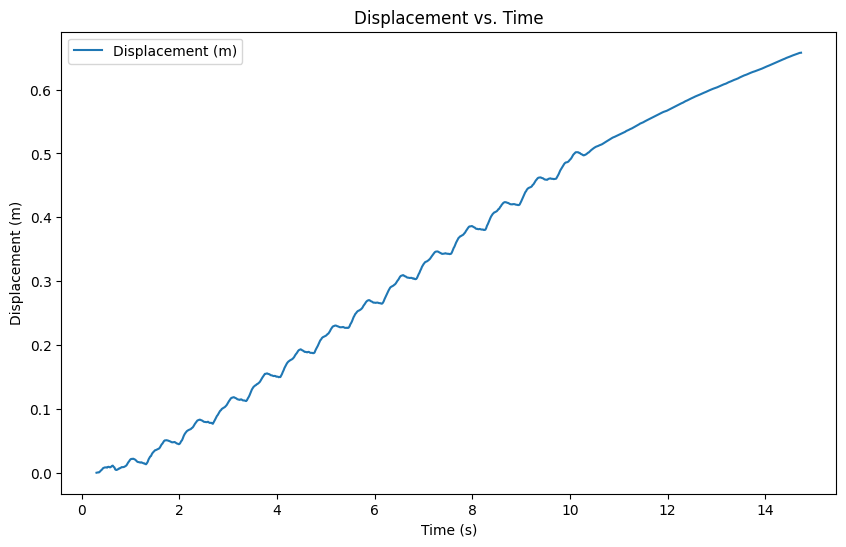

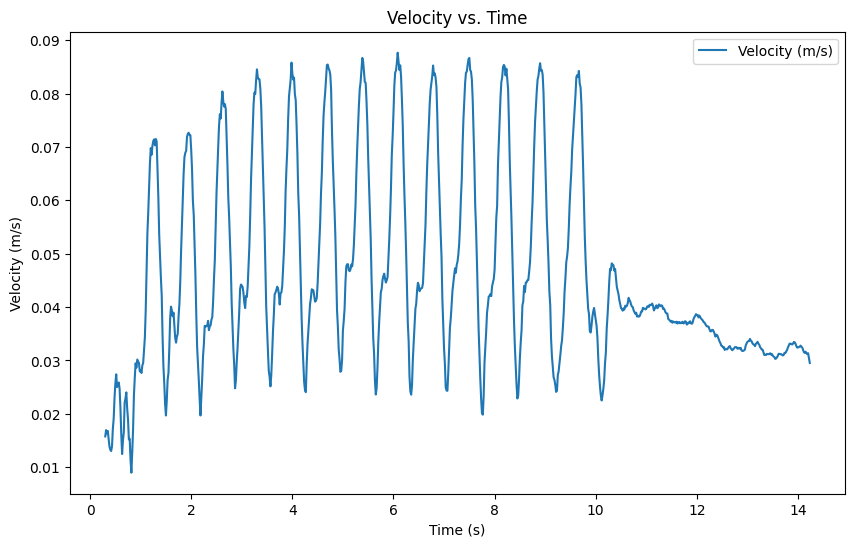

In [216]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


# Load the CSV file

file_path = '/Users/jamesxu/Downloads/coasting_luckyshot_16cm/videos/coastingDLC_resnet50_coastingNov13shuffle1_100000_filtered.csv'

x_length_meters=1.6
y_length_meters=0.9
fps=60
start_time=0.3
end_time=20

# Define normalization factors 
y_length_pixels = pd.to_numeric(df.iloc[2:, 1::2].max().max(), errors='coerce') - pd.to_numeric(df.iloc[2:, 1::2].min().min(), errors='coerce')
normalization_factor_y = y_length_meters / y_length_pixels

x_length_pixels = pd.to_numeric(df.iloc[2:, ::2].max().max(), errors='coerce') - pd.to_numeric(df.iloc[2:, ::2].min().min(), errors='coerce')
normalization_factor_x = x_length_meters / x_length_pixels

# Extract x and y coordinates for the markers, skipping the first two rows
coordinates_df = df.iloc[2:, :44].apply(pd.to_numeric, errors='coerce')  # Ensure numeric values

# Separate x and y coordinates and normalize them
x_coords = coordinates_df.iloc[:, ::2] * normalization_factor_x  # Normalize x-coordinates
y_coords = coordinates_df.iloc[:, 1::2] * normalization_factor_y  # Normalize y-coordinates

# Calculate mean position over markers
mean_x_position = x_coords.mean(axis=1).values
mean_y_position = y_coords.mean(axis=1).values

# Time array
time = np.arange(len(mean_x_position)) / fps

# Crop the data based on the start and end times
start_index = int(start_time * fps)
end_index = int(end_time * fps)
time = time[start_index:end_index]
mean_x_position = mean_x_position[start_index:end_index]
mean_y_position = mean_y_position[start_index:end_index]

# Calculate displacement from the initial position
initial_x, initial_y = mean_x_position[0], mean_y_position[0]
displacement = np.sqrt((mean_x_position - initial_x)**2 + (mean_y_position - initial_y)**2)

# User-defined time interval (in seconds) for velocity calculation
time_interval = 0.5  # for example, 0.5 seconds
interval_steps = int(time_interval * fps)  # Convert to number of frames

# Calculate velocity using displacement differences over the time interval
velocity = np.array([(displacement[i + interval_steps] - displacement[i]) / time_interval 
                     for i in range(len(displacement) - interval_steps)])

# Adjust the time array for velocity (since it has fewer elements due to the interval)
velocity_time = time[:len(velocity)]

# Plot displacement vs. time
plt.figure(figsize=(10, 6))
plt.plot(time, displacement, label="Displacement (m)")
plt.xlabel("Time (s)")
plt.ylabel("Displacement (m)")
plt.title("Displacement vs. Time")
plt.legend()
plt.show()

# Plot velocity vs. time
plt.figure(figsize=(10, 6))
plt.plot(velocity_time, velocity, label="Velocity (m/s)")
plt.xlabel("Time (s)")
plt.ylabel("Velocity (m/s)")
plt.title("Velocity vs. Time")
plt.legend()
plt.show()


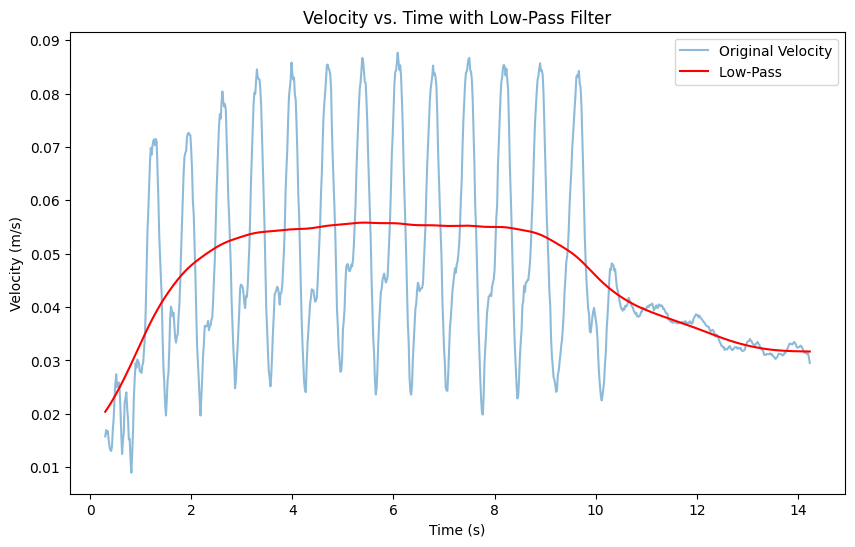

In [273]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt

# Load the CSV file
file_path = '/Users/jamesxu/Downloads/coasting_luckyshot_16cm/videos/coastingDLC_resnet50_coastingNov13shuffle1_100000_filtered.csv'
df = pd.read_csv(file_path)

# Parameters
x_length_meters = 1.6
y_length_meters = 0.9
fps = 60  # frames per second
start_time = 0.3
end_time = 20

# Define normalization factors 
y_length_pixels = pd.to_numeric(df.iloc[2:, 1::2].max().max(), errors='coerce') - pd.to_numeric(df.iloc[2:, 1::2].min().min(), errors='coerce')
normalization_factor_y = y_length_meters / y_length_pixels

x_length_pixels = pd.to_numeric(df.iloc[2:, ::2].max().max(), errors='coerce') - pd.to_numeric(df.iloc[2:, ::2].min().min(), errors='coerce')
normalization_factor_x = x_length_meters / x_length_pixels

# Extract x and y coordinates for the markers, skipping the first two rows
coordinates_df = df.iloc[2:, :44].apply(pd.to_numeric, errors='coerce')  # Ensure numeric values

# Separate x and y coordinates and normalize them
x_coords = coordinates_df.iloc[:, ::2] * normalization_factor_x  # Normalize x-coordinates
y_coords = coordinates_df.iloc[:, 1::2] * normalization_factor_y  # Normalize y-coordinates

# Calculate mean position over markers
mean_x_position = x_coords.mean(axis=1).values
mean_y_position = y_coords.mean(axis=1).values

# Time array
time = np.arange(len(mean_x_position)) / fps

# Crop the data based on the start and end times
start_index = int(start_time * fps)
end_index = int(end_time * fps)
time = time[start_index:end_index]
mean_x_position = mean_x_position[start_index:end_index]
mean_y_position = mean_y_position[start_index:end_index]

# Calculate displacement from the initial position
initial_x, initial_y = mean_x_position[0], mean_y_position[0]
displacement = np.sqrt((mean_x_position - initial_x)**2 + (mean_y_position - initial_y)**2)

# User-defined time interval (in seconds) for velocity calculation
time_interval = 0.5  # for example, 0.5 seconds
interval_steps = int(time_interval * fps)  # Convert to number of frames

# Calculate velocity using displacement differences over the time interval
velocity = np.array([(displacement[i + interval_steps] - displacement[i]) / time_interval 
                     for i in range(len(displacement) - interval_steps)])

# Adjust the time array for velocity (since it has fewer elements due to the interval)
velocity_time = time[:len(velocity)]

# Low-pass filter parameters
cutoff_frequency = 0.3 # Adjust this cutoff frequency as needed (in Hz)
order = 2  # Order of the filter, can be adjusted

# Convert the cutoff frequency to the Nyquist frequency (half the sampling rate)
nyquist_frequency = fps / 2
normalized_cutoff = cutoff_frequency / nyquist_frequency

# Design the Butterworth low-pass filter
b, a = butter(order, normalized_cutoff, btype='low', analog=False)

# Apply the low-pass filter to the velocity data
velocity_lowpass = filtfilt(b, a, velocity)

# Plot the original and low-pass filtered velocity
plt.figure(figsize=(10, 6))
plt.plot(velocity_time, velocity, label="Original Velocity", alpha=0.5)
plt.plot(velocity_time, velocity_lowpass, label="Low-Pass ", color='red')
plt.xlabel("Time (s)")
plt.ylabel("Velocity (m/s)")
plt.title("Velocity vs. Time with Low-Pass Filter")
plt.legend()
plt.show()


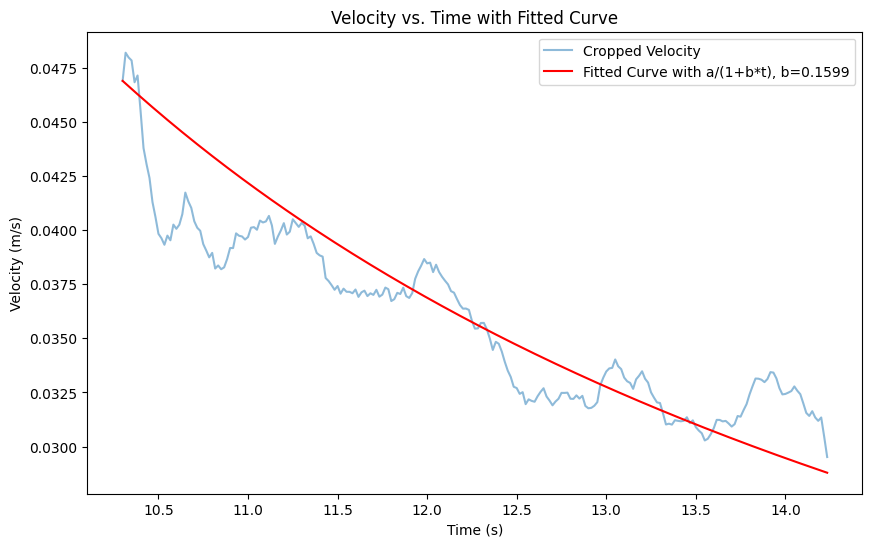

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# Load the CSV file
file_path = '/Users/jamesxu/Downloads/coasting_luckyshot_16cm/videos/coastingDLC_resnet50_coastingNov13shuffle1_100000_filtered.csv'
df = pd.read_csv(file_path)

# Parameters
x_length_meters = 1.6
y_length_meters = 0.9
fps = 60  # frames per second
start_time = 0.3
end_time = 20

# Define normalization factors 
y_length_pixels = pd.to_numeric(df.iloc[2:, 1::2].max().max(), errors='coerce') - pd.to_numeric(df.iloc[2:, 1::2].min().min(), errors='coerce')
normalization_factor_y = y_length_meters / y_length_pixels

x_length_pixels = pd.to_numeric(df.iloc[2:, ::2].max().max(), errors='coerce') - pd.to_numeric(df.iloc[2:, ::2].min().min(), errors='coerce')
normalization_factor_x = x_length_meters / x_length_pixels

# Extract x and y coordinates for the markers, skipping the first two rows
coordinates_df = df.iloc[2:, :44].apply(pd.to_numeric, errors='coerce')  # Ensure numeric values

# Separate x and y coordinates and normalize them
x_coords = coordinates_df.iloc[:, ::2] * normalization_factor_x  # Normalize x-coordinates
y_coords = coordinates_df.iloc[:, 1::2] * normalization_factor_y  # Normalize y-coordinates

# Calculate mean position over markers
mean_x_position = x_coords.mean(axis=1).values
mean_y_position = y_coords.mean(axis=1).values

# Time array
time = np.arange(len(mean_x_position)) / fps

# Crop the data based on the start and end times
start_index = int(start_time * fps)
end_index = int(end_time * fps)
time = time[start_index:end_index]
mean_x_position = mean_x_position[start_index:end_index]
mean_y_position = mean_y_position[start_index:end_index]

# Calculate displacement from the initial position
initial_x, initial_y = mean_x_position[0], mean_y_position[0]
displacement = np.sqrt((mean_x_position - initial_x)**2 + (mean_y_position - initial_y)**2)

# User-defined time interval (in seconds) for velocity calculation
time_interval = 0.5  # for example, 0.5 seconds
interval_steps = int(time_interval * fps)  # Convert to number of frames

# Calculate velocity using displacement differences over the time interval
velocity = np.array([(displacement[i + interval_steps] - displacement[i]) / time_interval 
                     for i in range(len(displacement) - interval_steps)])

# Adjust the time array for velocity (since it has fewer elements due to the interval)
velocity_time = time[:len(velocity)]

# Crop velocity data from t = 10.5 to the end
crop_start_time = 10.3
crop_start_index = np.searchsorted(velocity_time, crop_start_time)
velocity_cropped = velocity[crop_start_index:]
velocity_time_cropped = velocity_time[crop_start_index:]

# Set the initial value of a
a = velocity_cropped[0]

# Define the function for fitting
def fit_func(t, b):
    return a / (1 + b * (t - crop_start_time))

# Initial guess for b
initial_b = 0.1

# Perform the curve fitting
popt, _ = curve_fit(fit_func, velocity_time_cropped, velocity_cropped, p0=[initial_b])

# Extract the optimal value of b
optimal_b = popt[0]

# Generate fitted curve data
fitted_velocity = fit_func(velocity_time_cropped, optimal_b)

# Plot the cropped velocity and the fitted curve
plt.figure(figsize=(10, 6))
plt.plot(velocity_time_cropped, velocity_cropped, label="Cropped Velocity", alpha=0.5)
plt.plot(velocity_time_cropped, fitted_velocity, label=f"Fitted Curve with a/(1+b*t), b={optimal_b:.4f}", color='red')
plt.xlabel("Time (s)")
plt.ylabel("Velocity (m/s)")
plt.title("Velocity vs. Time with Fitted Curve")
plt.legend()
plt.show()


R-squared: 0.7035
p-value for b: 0.0000e+00


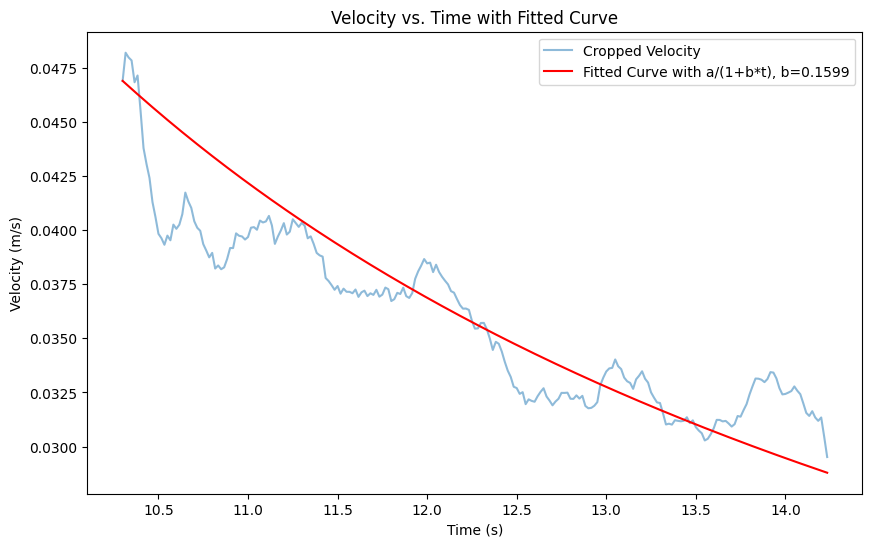

In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.stats import t

# Your existing code ...

# Perform the curve fitting
popt, pcov = curve_fit(fit_func, velocity_time_cropped, velocity_cropped, p0=[initial_b])

# Extract the optimal value of b
optimal_b = popt[0]

# Generate fitted curve data
fitted_velocity = fit_func(velocity_time_cropped, optimal_b)

# Calculate residuals
residuals = velocity_cropped - fitted_velocity

# Calculate R-squared
ss_res = np.sum(residuals**2)
ss_tot = np.sum((velocity_cropped - np.mean(velocity_cropped))**2)
r_squared = 1 - (ss_res / ss_tot)
print(f"R-squared: {r_squared:.4f}")

# Calculate standard error of the parameter b
perr = np.sqrt(np.diag(pcov))
se_b = perr[0]

# Degrees of freedom
n = len(velocity_cropped)      # number of data points
p = len(popt)                  # number of parameters
dof = max(0, n - p)            # degrees of freedom

# t-statistic for b (null hypothesis: b = 0)
t_stat = (optimal_b - 0) / se_b

# Calculate p-value
p_value = 2 * (1 - t.cdf(np.abs(t_stat), dof))
print(f"p-value for b: {p_value:.4e}")

# Plot the cropped velocity and the fitted curve
plt.figure(figsize=(10, 6))
plt.plot(velocity_time_cropped, velocity_cropped, label="Cropped Velocity", alpha=0.5)
plt.plot(velocity_time_cropped, fitted_velocity, label=f"Fitted Curve with a/(1+b*t), b={optimal_b:.4f}", color='red')
plt.xlabel("Time (s)")
plt.ylabel("Velocity (m/s)")
plt.title("Velocity vs. Time with Fitted Curve")
plt.legend()
plt.show()



In [5]:
from scipy.stats import t

# Calculate R^2 (Coefficient of Determination)
residuals = velocity_cropped - fitted_velocity
ss_res = np.sum(residuals**2)  # Sum of squared residuals
ss_tot = np.sum((velocity_cropped - np.mean(velocity_cropped))**2)  # Total sum of squares
r_squared = 1 - (ss_res / ss_tot)

# Display R^2
print(f"R^2: {r_squared:.4f}")

# Calculate p-value for the parameter b more carefully
# Obtain the covariance matrix from the curve_fit function
popt, pcov = curve_fit(fit_func, velocity_time_cropped, velocity_cropped, p0=[initial_b])
b_std_error = np.sqrt(np.diag(pcov))[0]  # Standard error of b

# Degrees of freedom: number of observations - number of fitted parameters
dof = len(velocity_cropped) - len(popt) 

# Avoid division by zero in case of very small standard error
if b_std_error > 1e-10:  # Threshold to prevent issues with near-zero errors
    # t-statistic for b
    t_stat = optimal_b / b_std_error

    # Calculate two-tailed p-value
    p_value = 2 * (1 - t.cdf(abs(t_stat), dof))
else:
    p_value = 1.0  # If standard error is too small, set p-value to 1 (indicating low significance)

# Display p-value
print(f"p-value for b: {p_value:.4f}")


R^2: 0.7035
p-value for b: 0.0000


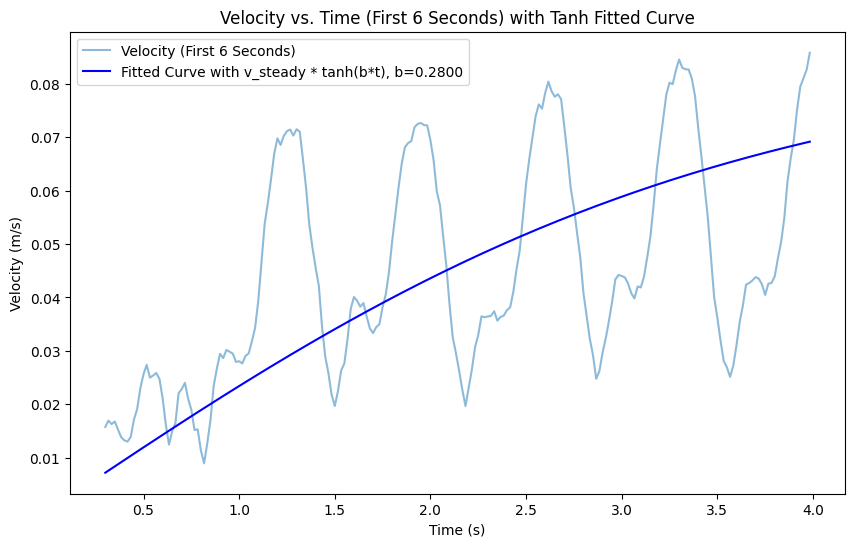

In [21]:
# Define the duration for this fitting (first 6 seconds of data)
fit_end_time = 4.0 # seconds
fit_end_index = np.searchsorted(time, fit_end_time)

# Extract data for the first 6 seconds
time_first_6s = time[:fit_end_index]
velocity_first_6s = velocity[:fit_end_index]

# Set the value of v_steady as velocity at t = 6s
v_steady = velocity_first_6s[-1]

# Define the tanh function for fitting
def tanh_fit_func(t, b):
    return v_steady * np.tanh(b * t)

# Initial guess for b
initial_b_tanh = 0.1

# Perform the curve fitting for the tanh function
popt_tanh, _ = curve_fit(tanh_fit_func, time_first_6s, velocity_first_6s, p0=[initial_b_tanh])

# Extract the optimal value of b
optimal_b_tanh = popt_tanh[0]

# Generate fitted curve data for the tanh function
fitted_velocity_tanh = tanh_fit_func(time_first_6s, optimal_b_tanh)

# Plot the velocity and the fitted tanh curve for the first 6 seconds
plt.figure(figsize=(10, 6))
plt.plot(time_first_6s, velocity_first_6s, label="Velocity (First 6 Seconds)", alpha=0.5)
plt.plot(time_first_6s, fitted_velocity_tanh, label=f"Fitted Curve with v_steady * tanh(b*t), b={optimal_b_tanh:.4f}", color='blue')
plt.xlabel("Time (s)")
plt.ylabel("Velocity (m/s)")
plt.title("Velocity vs. Time (First 6 Seconds) with Tanh Fitted Curve")
plt.legend()
plt.show()


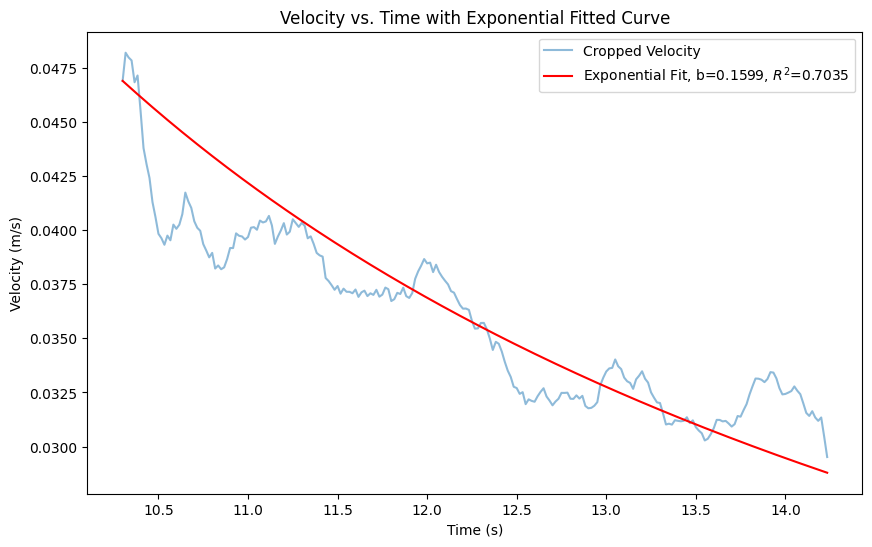

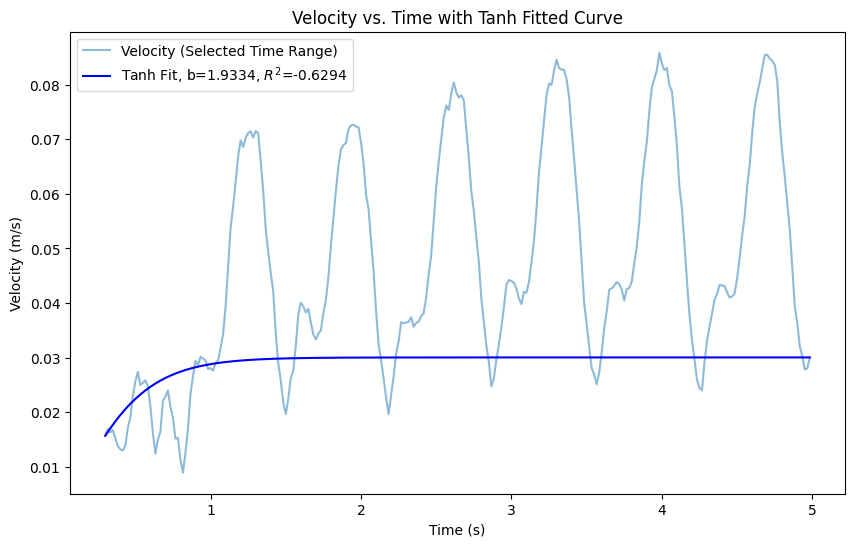

In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# Load the CSV file
file_path = '/Users/jamesxu/Downloads/coasting_luckyshot_16cm/videos/coastingDLC_resnet50_coastingNov13shuffle1_100000_filtered.csv'
df = pd.read_csv(file_path)

# Parameters
x_length_meters = 1.6
y_length_meters = 0.9
fps = 60  # frames per second
start_time = 0.3
end_time = 20

# Define normalization factors 
y_length_pixels = pd.to_numeric(df.iloc[2:, 1::2].max().max(), errors='coerce') - pd.to_numeric(df.iloc[2:, 1::2].min().min(), errors='coerce')
normalization_factor_y = y_length_meters / y_length_pixels

x_length_pixels = pd.to_numeric(df.iloc[2:, ::2].max().max(), errors='coerce') - pd.to_numeric(df.iloc[2:, ::2].min().min(), errors='coerce')
normalization_factor_x = x_length_meters / x_length_pixels

# Extract x and y coordinates for the markers, skipping the first two rows
coordinates_df = df.iloc[2:, :44].apply(pd.to_numeric, errors='coerce')  # Ensure numeric values

# Separate x and y coordinates and normalize them
x_coords = coordinates_df.iloc[:, ::2] * normalization_factor_x  # Normalize x-coordinates
y_coords = coordinates_df.iloc[:, 1::2] * normalization_factor_y  # Normalize y-coordinates

# Calculate mean position over markers
mean_x_position = x_coords.mean(axis=1).values
mean_y_position = y_coords.mean(axis=1).values

# Time array
time = np.arange(len(mean_x_position)) / fps

# Crop the data based on the start and end times
start_index = int(start_time * fps)
end_index = int(end_time * fps)
time = time[start_index:end_index]
mean_x_position = mean_x_position[start_index:end_index]
mean_y_position = mean_y_position[start_index:end_index]

# Calculate displacement from the initial position
initial_x, initial_y = mean_x_position[0], mean_y_position[0]
displacement = np.sqrt((mean_x_position - initial_x)**2 + (mean_y_position - initial_y)**2)

# User-defined time interval (in seconds) for velocity calculation
time_interval = 0.5
interval_steps = int(time_interval * fps)

# Calculate velocity using displacement differences over the time interval
velocity = np.array([(displacement[i + interval_steps] - displacement[i]) / time_interval 
                     for i in range(len(displacement) - interval_steps)])

# Adjust the time array for velocity
velocity_time = time[:len(velocity)]

# Exponential fitting from a specific time
crop_start_time = 10.3
crop_start_index = np.searchsorted(velocity_time, crop_start_time)
velocity_cropped = velocity[crop_start_index:]
velocity_time_cropped = velocity_time[crop_start_index:]

# Set the initial value of a for exponential fitting
a = velocity_cropped[0]

# Define the function for exponential fitting
def fit_func(t, b):
    return a / (1 + b * (t - crop_start_time))

# Perform the curve fitting for the exponential function
popt, _ = curve_fit(fit_func, velocity_time_cropped, velocity_cropped, p0=[0.1])
optimal_b = popt[0]

# Generate fitted curve data for the exponential function
fitted_velocity = fit_func(velocity_time_cropped, optimal_b)

# Calculate R^2 for exponential fitting
residuals_exp = velocity_cropped - fitted_velocity
ss_res_exp = np.sum(residuals_exp**2)
ss_tot_exp = np.sum((velocity_cropped - np.mean(velocity_cropped))**2)
r_squared_exp = 1 - (ss_res_exp / ss_tot_exp)

# Plot exponential fit
plt.figure(figsize=(10, 6))
plt.plot(velocity_time_cropped, velocity_cropped, label="Cropped Velocity", alpha=0.5)
plt.plot(velocity_time_cropped, fitted_velocity, label=f"Exponential Fit, b={optimal_b:.4f}, $R^2$={r_squared_exp:.4f}", color='red')
plt.xlabel("Time (s)")
plt.ylabel("Velocity (m/s)")
plt.title("Velocity vs. Time with Exponential Fitted Curve")
plt.legend()
plt.show()

# Tanh fitting for an adjustable time range 
fit_end_time = 5  # Adjustable
fit_end_index = np.searchsorted(time, fit_end_time)

# Extract data for the selected time range
time_selected = time[:fit_end_index]
velocity_selected = velocity[:fit_end_index]

# Set the value of v_steady as velocity at the selected end time
v_steady = velocity_selected[-1]

# Define the tanh function for fitting
def tanh_fit_func(t, b):
    return v_steady * np.tanh(b * t)

# Perform the curve fitting for the tanh function
popt_tanh, _ = curve_fit(tanh_fit_func, time_selected, velocity_selected, p0=[0.1])
optimal_b_tanh = popt_tanh[0]

# Generate fitted curve data for the tanh function
fitted_velocity_tanh = tanh_fit_func(time_selected, optimal_b_tanh)

# Calculate R^2 for tanh fitting
residuals_tanh = velocity_selected - fitted_velocity_tanh
ss_res_tanh = np.sum(residuals_tanh**2)
ss_tot_tanh = np.sum((velocity_selected - np.mean(velocity_selected))**2)
r_squared_tanh = 1 - (ss_res_tanh / ss_tot_tanh)

# Plot tanh fit
plt.figure(figsize=(10, 6))
plt.plot(time_selected, velocity_selected, label="Velocity (Selected Time Range)", alpha=0.5)
plt.plot(time_selected, fitted_velocity_tanh, label=f"Tanh Fit, b={optimal_b_tanh:.4f}, $R^2$={r_squared_tanh:.4f}", color='blue')
plt.xlabel("Time (s)")
plt.ylabel("Velocity (m/s)")
plt.title("Velocity vs. Time with Tanh Fitted Curve")
plt.legend()
plt.show()


In [32]:
p_value 

0.0

In [33]:
n

237

In [34]:
p

1

In [37]:
from scipy.optimize import curve_fit
import numpy as np

x =np.linspace(0,5,100) 
noise = np.random.normal(0,1,100) 
y= (1.5 * x + 2) + noise

def f(x,b0,b1):
    return b0 + (b1 * x)

parameters, cov= curve_fit(f, x, y)
print(parameters)

[[ 0.03584136 -0.01069838]
 [-0.01069838  0.00427935]]
